# Q1. (40 points) Feature extraction and matching

   (use the images from https://sourceforge.net/projects/adobedatasets.adobe/files/adobe_panoramas.tgz/download)  
    a. (10 points) Select and implement one of the point feature detectors we have explained or use other methods you learned about. (Make sure to implement the feature detector yourself). Explain your selected detector and show the results.   
    b. (20 points) Implement a simple feature matching by using two feature descriptors of your choice (you can use the available feature descriptors in OpenCV or Matlab). Compare the two feature descriptors and the matching results on a few different images.  
    c. (10 points) Instead of finding feature points independently in multiple images and then matching them, find features in the first image of a video or image sequence and then re-locate the corresponding points in the next frames using search and gradient descent (Shi and Tomasi 1994). When the number of tracked points drops below a threshold or new regions in the image become visible, find additional points to track.

## 1a.  Harris Corner Point detection

The feature I implemented is Harris corner point. The defail info can be found at [wikipedia](https://en.wikipedia.org/wiki/Corner_detection#The_Harris_&_Stephens_/_Shi%E2%80%93Tomasi_corner_detection_algorithms)

The key function is `get_harris_points`, the detail code can be found in assignment_code.py ane extra function `display_corner_points` is written for display finding point on image as red point.

In [1]:
import numpy as np
import cv2
from pprint import pprint
from scipy import ndimage
from skimage.feature import corner_peaks


def imfilter(I, filter)->np.ndarray:
    I_f = ndimage.filters.correlate(I, weights=filter, mode='constant')
    return I_f


def get_harris_points(I, k=0.05):

    # check image and convert to gray and normalize
    if len(I.shape) == 3 and I.shape[2] == 3:
        I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
    if I.max() > 1.0:
        I = I / 255.0

    # Step 1 calcualte Axx, Axy and Ayy
    
    # Step 1.1 calculate Ix, Iy
    # apply soble filter for quick calculation
    filter_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) / \
        8.0  # sobel filter for x derivative
    filter_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]) / \
        8.0  # sobel filter for y derivative

    Ix = imfilter(I, filter_x)
    Iy = imfilter(I, filter_y)
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    window = np.ones((3, 3))

    Axx = imfilter(Ixx, window)
    Axy = imfilter(Ixy, window)
    Ayy = imfilter(Iyy, window)

    # Step 2 calculate response
    # determinant
    detA = Axx * Ayy - Axy ** 2
    # trace
    traceA = Axx + Ayy
    # response
    response = detA - k * traceA ** 2

    # step 3. Get points location(x,y)
    points = corner_peaks(response,min_distance=4)
    # points = get_coordinate(response,I.shape)

    return points

def display_corner_points(org_img:np.ndarray, points, output_name):
    bool_arr = np.zeros(org_img.shape[:2],dtype=np.int8)
    bool_arr = np.bool8(bool_arr)
    
    # pprint(bool_arr)
    for (x,y) in points:
        bool_arr[x,y] = True
    
    # pprint(bool_arr)
    org_img[bool_arr]=[0,0,255]
    cv2.imwrite(output_name, org_img)



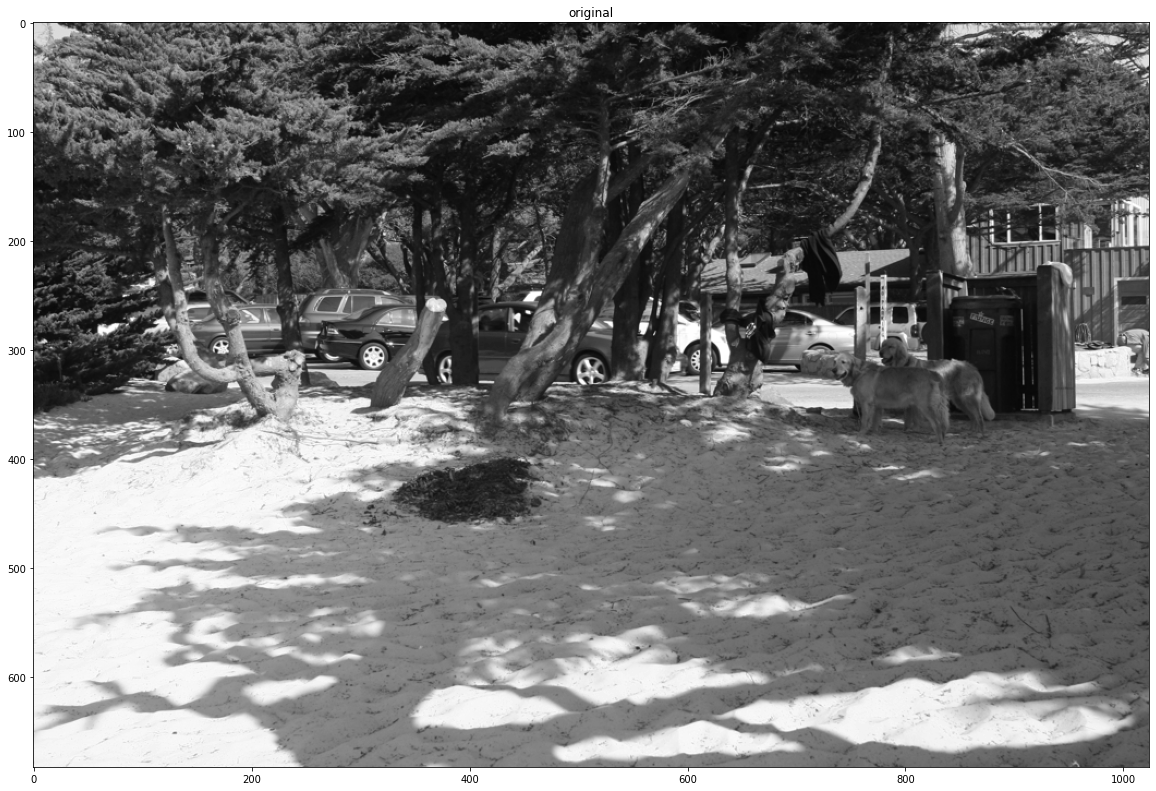

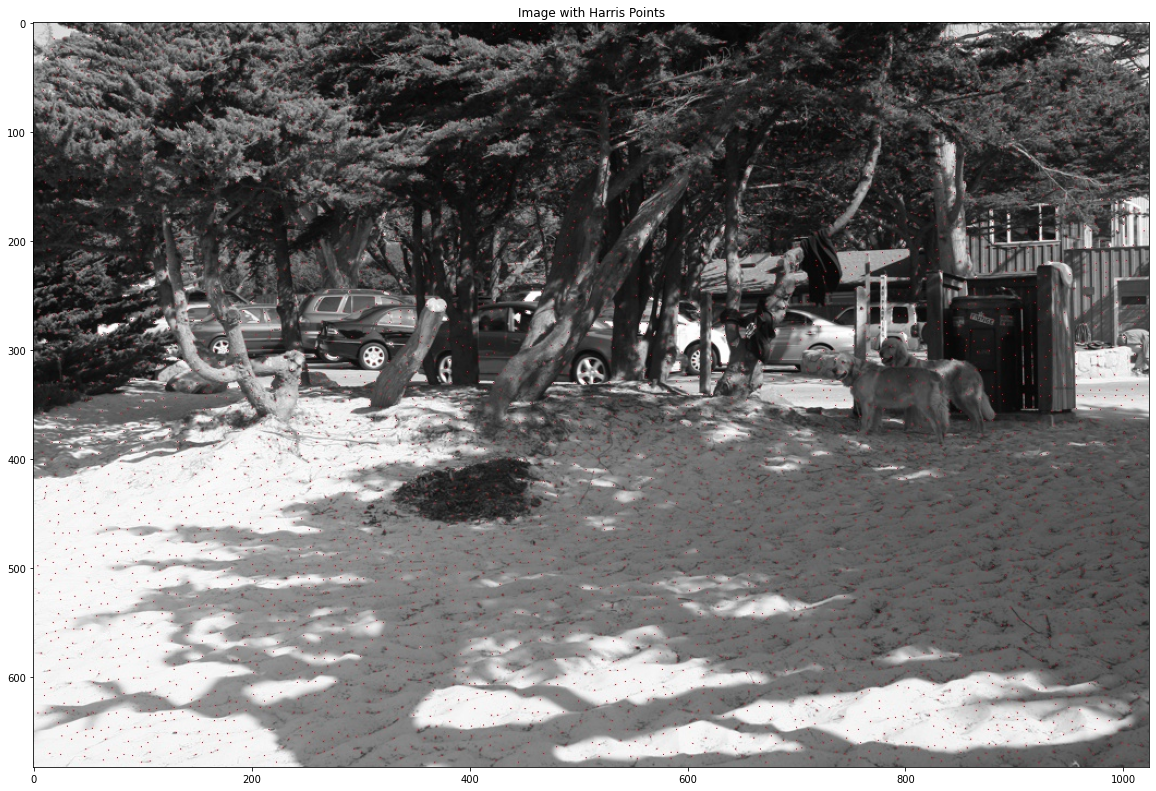

In [3]:
# showing result
import matplotlib.pyplot as plt

image_name = "data/carmel/carmel-00.png"
image = cv2.imread(image_name,cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(20, 15))
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title("original")
plt.show()


I = cv2.imread(image_name)
grey = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
grey = grey / 255.0
points = get_harris_points(grey)
output_name = f"./output/a_harris_output.jpg"
display_corner_points(I,points,output_name)
image2 = cv2.imread(output_name)
image2 = cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 15))
plt.imshow(image2)
plt.title("Image with Harris Points")
plt.show()



## 1B. Feature Matching
Implement a simple feature matching by using two feature descriptors of your choice (you can use the available feature descriptors in OpenCV or Matlab). Compare the two feature descriptors and the matching results on a few different images. 

The first option is using Basics of Brute-Force Matcher with ORB feature descriptor
The sceond option is using Basics of Brute-Force Matcher with SIFT feature descriptor

The ORB gives better result, for example the table corner is matched by ORB but not SIFT

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt


def BF_match_orb(img1, img2):
    # Initiate ORB detector
    orb = cv.ORB_create()
    # find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)

    # create BFMatcher object
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    # Match descriptors.
    matches = bf.match(des1,des2)
    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    # Draw first 10 matches.
    img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:50],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(15, 10))
    plt.imshow(img3)
    plt.title('orb')
    plt.show()
    
    

def BF_match_sift(img1,img2):
    # Initiate SIFT detector
    sift = cv.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])
    # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good[:50],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(15, 10))
    plt.imshow(img3)
    plt.title('sift')
    plt.show()




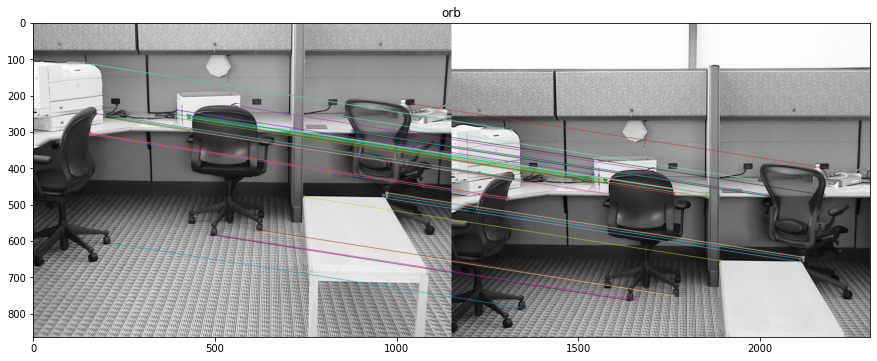

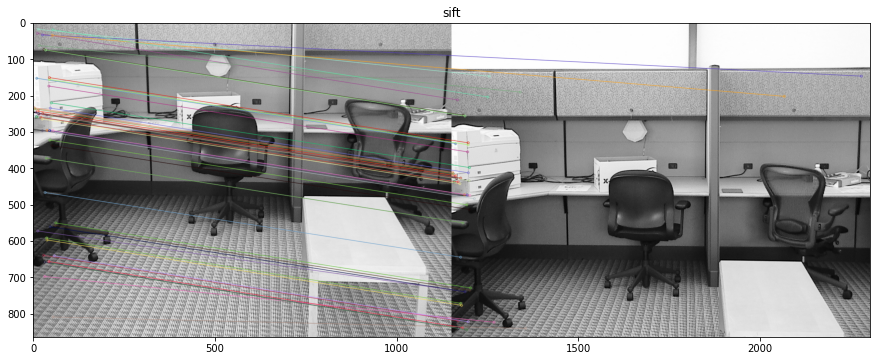

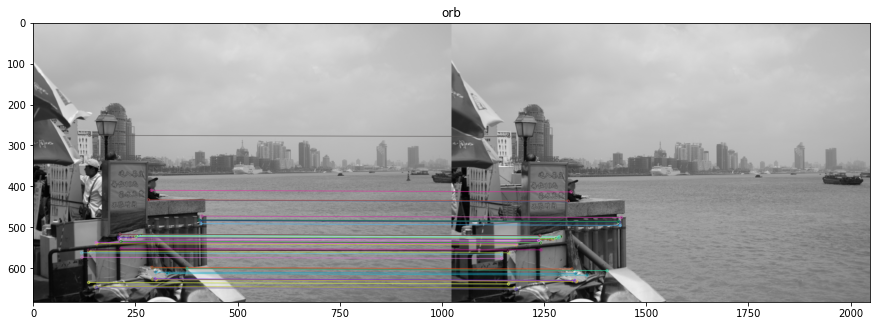

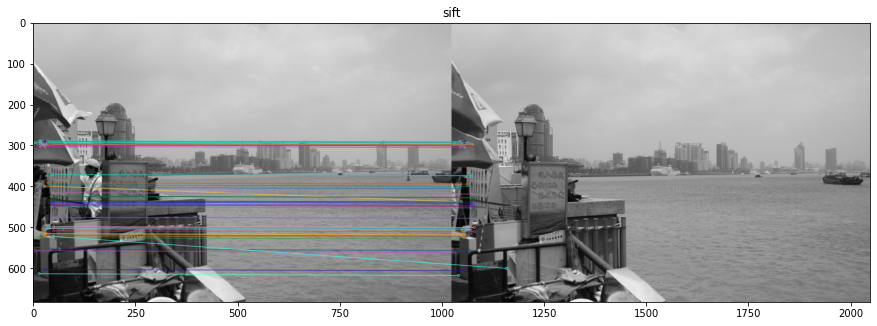

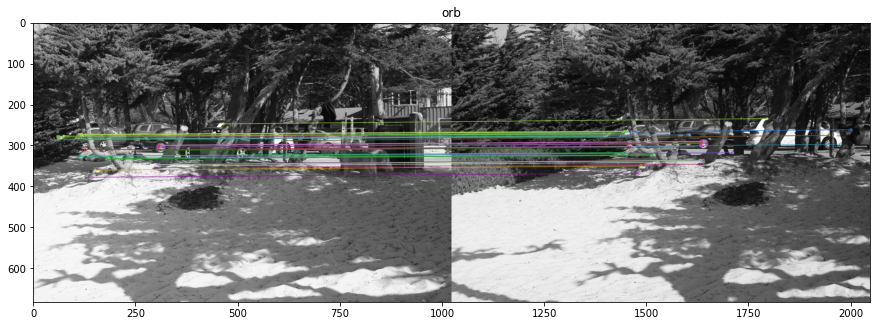

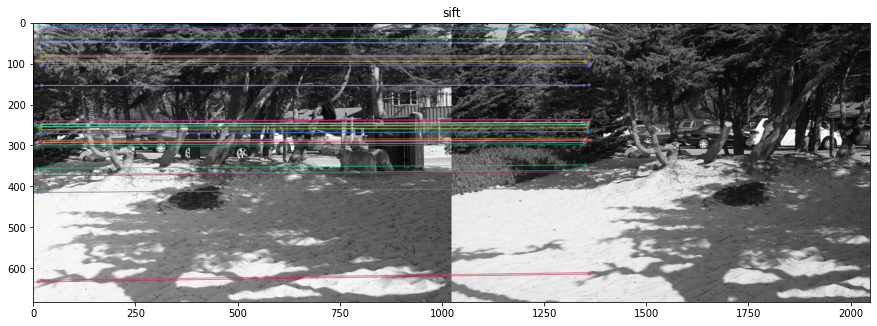

In [4]:
img_name1 = './data/office/office-00.png'
img_name2 = './data/office/office-01.png'

images = [    
    './data/office/office-00.png',
    './data/office/office-01.png',
    './data/shanghai/shanghai-00.png',
    './data/shanghai/shanghai-01.png',
    './data/carmel/carmel-00.png',
    './data/carmel/carmel-01.png',
]

n = len(images)//2
for i in range(n):
    img1 = cv.imread(images[2*i],cv.IMREAD_GRAYSCALE)          # queryImage
    img2 = cv.imread(images[2*i + 1],cv.IMREAD_GRAYSCALE) # trainImage

    BF_match_orb(img1,img2)

    BF_match_sift(img1,img2)

